
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names and student numbers:<br>
امیرمهدی وزیری - 402106756<br>
سینا اصولی‌نژاد - 402170884<br>
محمدمهدی عابدینی - 402106191
 </font>

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [2]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [1]:
DATA_DIR = '/content/drive/MyDrive/massachusetts-roads-dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 2
LR = 6e-4
NUM_EPOCHS = 15

# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [3]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/massachusetts-roads-dataset


If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [8]:
from google.colab import drive

drive.mount('/content/drive')

shutil.move(path, '/content/drive/MyDrive/')

Mounted at /content/drive


Error: Destination path '/content/drive/MyDrive/massachusetts-roads-dataset' already exists

### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [9]:
def load_images_and_masks(images_path, masks_path, image_size):
    """
    Returns sorted full file paths for images and masks so Dataset can load on-demand.
    """
    exts = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')
    img_files  = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.lower().endswith(exts)])
    mask_files = sorted([os.path.join(masks_path,  f) for f in os.listdir(masks_path)  if f.lower().endswith(exts)])
    assert len(img_files) == len(mask_files) and len(img_files) > 0, "Image/Mask count mismatch or empty!"
    return img_files, mask_files

# Define training image and mask directories
train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir  = os.path.join(DATA_DIR, 'tiff/train_labels')

# Get paths or filenames for training images and masks (placeholder)
train_images_path = train_images_dir
train_masks_path  = train_masks_dir

# Load and preprocess training images and masks
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)

# Define validation image and mask directories
val_images_dir = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir  = os.path.join(DATA_DIR, 'tiff/val_labels')

# Get paths or filenames for validation images and masks (placeholder)
val_images_path = val_images_dir
val_masks_path  = val_masks_dir

# Load and preprocess validation images and masks
val_images, val_masks = load_images_and_masks(val_images_path, val_masks_path, IMAGE_SIZE)


### Data Visualization

Display the images and their masks for several samples.

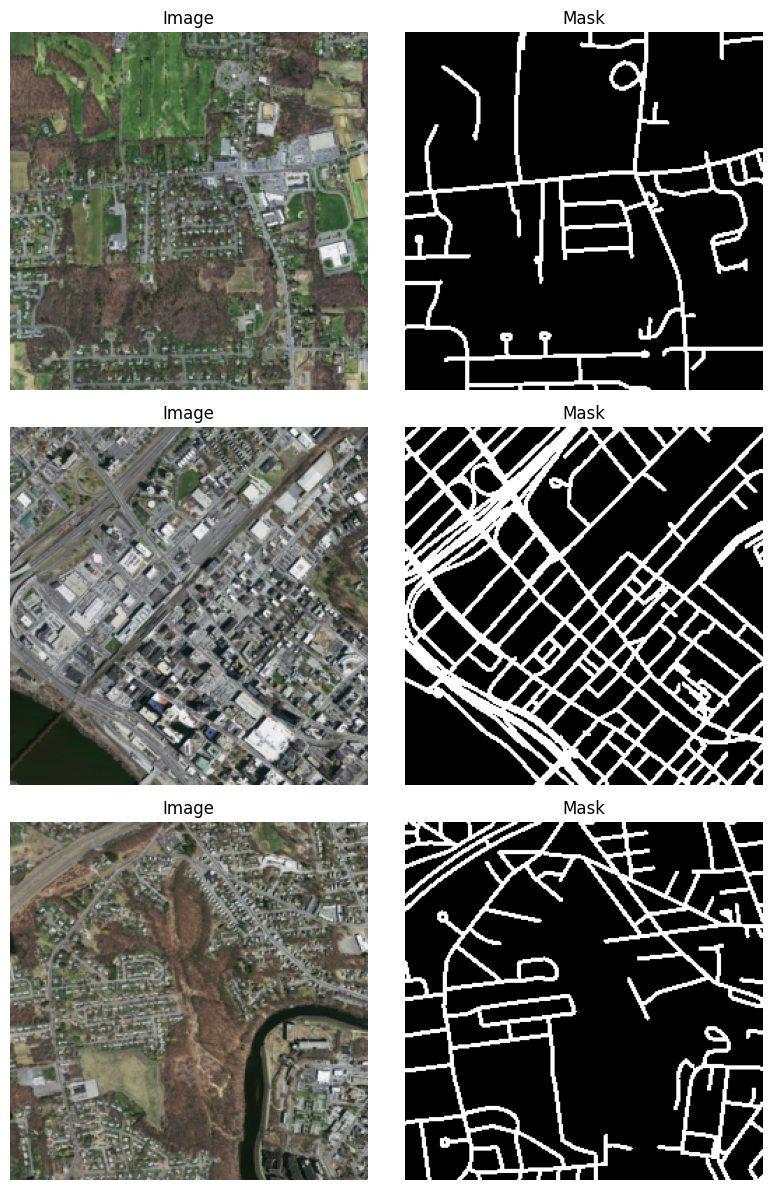

In [29]:
def visualize_images_and_masks(n=3):

    with torch.no_grad():
        imgs, msks = next(iter(val_loader))

    images = imgs.cpu()
    masks = msks.cpu()

    b = min(n, images.size(0))
    plt.figure(figsize=(12, 4 * b))
    for i in range(b):
        img  = images[i].permute(1, 2, 0).numpy()
        msk  = masks[i, 0].numpy()

        plt.subplot(b, 3, 3*i + 1); plt.imshow(img);  plt.axis('off'); plt.title('Image')
        plt.subplot(b, 3, 3*i + 2); plt.imshow(msk,  cmap='gray'); plt.axis('off'); plt.title('Mask')

    plt.tight_layout()
    plt.show()

visualize_images_and_masks()

### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [11]:
class RoadDataset(Dataset):
    """
    Loads images/masks from file paths; applies transforms; returns tensors.
    """
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform  = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = Image.open(self.images[idx]).convert('RGB')
      mask  = Image.open(self.masks[idx]).convert('L')

      if self.image_transform:
          image = self.image_transform(image)
      if self.mask_transform:
          mask = self.mask_transform(mask)

      return image, mask


### Define your desired transformations
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.BILINEAR),
    transforms.ToTensor(),  # [0,1]
])

mask_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.PILToTensor(),
    transforms.Lambda(lambda t: (t > 1).to(torch.float32))
])


train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images,   val_masks,   image_transform, mask_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [13]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2)
    def forward(self, x):
        return self.upconv(x)

### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__()
        f1, f2, f3, f4 = filter

        # Encoder
        self.enc1 = ConvBlock(in_channel, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(f3, f4)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(f4, f4*2)

        # Decoder
        self.up4 = UpConvBlock(f4*2, f4)
        self.dec4 = ConvBlock(f4*2, f4)
        self.up3 = UpConvBlock(f4, f3)
        self.dec3 = ConvBlock(f3*2, f3)
        self.up2 = UpConvBlock(f3, f2)
        self.dec2 = ConvBlock(f2*2, f2)
        self.up1 = UpConvBlock(f2, f1)
        self.dec1 = ConvBlock(f1*2, f1)

        self.final = nn.Conv2d(f1, out_channel, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))

        # Decoder
        d4 = self.up4(x5)
        d4 = self.dec4(torch.cat([d4, x4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, x3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, x2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, x1], dim=1))

        out = self.final(d1)
        out = torch.sigmoid(out)
        return out


# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [15]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int),
        )
        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int),
        )
        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        self.act = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: gating (decoder), x: skip (encoder)
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.act(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [16]:
class AttentionUNet(UNet):
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)
        f1, f2, f3, f4 = filter_sizes

        self.att4 = AttentionBlock(f_g=f4, f_l=f4, f_int=f4 // 2)
        self.att3 = AttentionBlock(f_g=f3, f_l=f3, f_int=f3 // 2)
        self.att2 = AttentionBlock(f_g=f2, f_l=f2, f_int=f2 // 2)
        self.att1 = AttentionBlock(f_g=f1, f_l=f1, f_int=f1 // 2)

    def forward(self, x):
        # Encoder (reuse the parent defined layers)
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))

        # Decoder with attention gates
        d4 = self.up4(x5)
        x4_att = self.att4(d4, x4)
        d4 = self.dec4(torch.cat([d4, x4_att], dim=1))

        d3 = self.up3(d4)
        x3_att = self.att3(d3, x3)
        d3 = self.dec3(torch.cat([d3, x3_att], dim=1))

        d2 = self.up2(d3)
        x2_att = self.att2(d2, x2)
        d2 = self.dec2(torch.cat([d2, x2_att], dim=1))

        d1 = self.up1(d2)
        x1_att = self.att1(d1, x1)
        d1 = self.dec1(torch.cat([d1, x1_att], dim=1))

        out = self.final(d1)
        out = torch.sigmoid(out)
        return out


# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [17]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
        ) if in_channel != out_channel else nn.Identity()
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.act(out + residual)
        return out


Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [18]:
class ResidualAttentionUNet(AttentionUNet):
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        nn.Module.__init__(self)
        f1, f2, f3, f4 = filter_sizes

        # Encoder (residual)
        self.enc1 = ResidualConvBlock(in_channel, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResidualConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualConvBlock(f3, f4)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResidualConvBlock(f4, f4*2)

        # Decoder (residual)
        self.up4 = UpConvBlock(f4*2, f4)
        self.dec4 = ResidualConvBlock(f4*2, f4)
        self.up3 = UpConvBlock(f4, f3)
        self.dec3 = ResidualConvBlock(f3*2, f3)
        self.up2 = UpConvBlock(f3, f2)
        self.dec2 = ResidualConvBlock(f2*2, f2)
        self.up1 = UpConvBlock(f2, f1)
        self.dec1 = ResidualConvBlock(f1*2, f1)

        self.final = nn.Conv2d(f1, out_channel, kernel_size=1)

        # Attentions
        self.att4 = AttentionBlock(f_g=f4, f_l=f4, f_int=f4 // 2)
        self.att3 = AttentionBlock(f_g=f3, f_l=f3, f_int=f3 // 2)
        self.att2 = AttentionBlock(f_g=f2, f_l=f2, f_int=f2 // 2)
        self.att1 = AttentionBlock(f_g=f1, f_l=f1, f_int=f1 // 2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))

        d4 = self.up4(x5)
        x4_att = self.att4(d4, x4)
        d4 = self.dec4(torch.cat([d4, x4_att], dim=1))

        d3 = self.up3(d4)
        x3_att = self.att3(d3, x3)
        d3 = self.dec3(torch.cat([d3, x3_att], dim=1))

        d2 = self.up2(d3)
        x2_att = self.att2(d2, x2)
        d2 = self.dec2(torch.cat([d2, x2_att], dim=1))

        d1 = self.up1(d2)
        x1_att = self.att1(d1, x1)
        d1 = self.dec1(torch.cat([d1, x1_att], dim=1))

        out = self.final(d1)
        out = torch.sigmoid(out)
        return out


# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        # assume pred already sigmoid; clamp for numerical stability
        pred = pred.clamp(0, 1)
        real = real.float()
        pred_flat = pred.view(pred.size(0), -1)
        real_flat = real.view(real.size(0), -1)
        intersection = (pred_flat * real_flat).sum(dim=1)
        denom = pred_flat.sum(dim=1) + real_flat.sum(dim=1)
        dice_coeff = (2 * intersection + self.smooth) / (denom + self.smooth)
        return 1 - dice_coeff.mean()

class IouLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.clamp(0, 1)
        real = real.float()
        pred_flat = pred.view(pred.size(0), -1)
        real_flat = real.view(real.size(0), -1)
        intersection = (pred_flat * real_flat).sum(dim=1)
        union = pred_flat.sum(dim=1) + real_flat.sum(dim=1) - intersection
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou_coeff.mean()


### Overall Loss (DO NOT CHANGE)
class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce

### Training Epoch

Complete the function below to train the model for one epoch.

In [20]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    total_loss = 0.0
    model.train()
    for img, mask in tqdm(data_loader):
        img  = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        pred = model(img)
        _, _, _, loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            try:
                scheduler.step()
            except Exception:
                pass

        total_loss += loss.item()

    return total_loss / len(data_loader)



Design a function for evaluation after each training phase.

In [21]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    model.eval()
    with torch.no_grad():
        for img, mask in tqdm(data_loader):
            img  = img.to(device)
            mask = mask.to(device)

            pred = model(img)
            dice_loss, iou_loss, bce_loss, overall_loss = criterion(pred, mask)

            total_loss += overall_loss.item()
            iou_score  += (1 - iou_loss.item())
            dice_score += (1 - dice_loss.item())

    total_loss /= len(data_loader)
    iou_score  /= len(data_loader)
    dice_score /= len(data_loader)
    return total_loss, iou_score, dice_score


# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [30]:
torch.cuda.empty_cache() # free up memory space
unet = UNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(unet.parameters(), lr=LR)
# Add a scheduler if you like

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Iteration 1/15: Train Loss: 1.58 | Val Loss: 1.18 | Iou Score: 0.49 | Dice Score: 0.66


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Iteration 2/15: Train Loss: 1.22 | Val Loss: 0.94 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


Iteration 3/15: Train Loss: 1.12 | Val Loss: 0.98 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Iteration 4/15: Train Loss: 1.08 | Val Loss: 0.82 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Iteration 5/15: Train Loss: 1.05 | Val Loss: 0.88 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Iteration 6/15: Train Loss: 1.04 | Val Loss: 0.80 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


Iteration 7/15: Train Loss: 1.01 | Val Loss: 0.83 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Iteration 8/15: Train Loss: 0.99 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Iteration 9/15: Train Loss: 1.00 | Val Loss: 0.78 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Iteration 10/15: Train Loss: 0.98 | Val Loss: 0.75 | Iou Score: 0.66 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Iteration 11/15: Train Loss: 0.96 | Val Loss: 0.73 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Iteration 12/15: Train Loss: 0.95 | Val Loss: 0.72 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


Iteration 13/15: Train Loss: 0.96 | Val Loss: 0.79 | Iou Score: 0.65 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Iteration 14/15: Train Loss: 0.93 | Val Loss: 0.72 | Iou Score: 0.68 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

Iteration 15/15: Train Loss: 0.93 | Val Loss: 0.74 | Iou Score: 0.67 | Dice Score: 0.80


Now do the same for Attention UNet and Reidual Attention UNet.

In [22]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_unet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:25<00:00,  6.39s/it]


Iteration 1/15: Train Loss: 1.55 | Val Loss: 1.09 | Iou Score: 0.50 | Dice Score: 0.67


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Iteration 2/15: Train Loss: 1.19 | Val Loss: 0.96 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Iteration 3/15: Train Loss: 1.12 | Val Loss: 0.90 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Iteration 4/15: Train Loss: 1.09 | Val Loss: 0.89 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


Iteration 5/15: Train Loss: 1.06 | Val Loss: 0.80 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Iteration 6/15: Train Loss: 1.04 | Val Loss: 0.77 | Iou Score: 0.65 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Iteration 7/15: Train Loss: 1.01 | Val Loss: 0.81 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Iteration 8/15: Train Loss: 1.01 | Val Loss: 0.79 | Iou Score: 0.65 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Iteration 9/15: Train Loss: 0.99 | Val Loss: 0.75 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Iteration 10/15: Train Loss: 0.98 | Val Loss: 0.78 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Iteration 11/15: Train Loss: 0.97 | Val Loss: 0.74 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Iteration 12/15: Train Loss: 0.96 | Val Loss: 0.73 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Iteration 13/15: Train Loss: 0.95 | Val Loss: 0.76 | Iou Score: 0.66 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


Iteration 14/15: Train Loss: 0.95 | Val Loss: 0.79 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

Iteration 15/15: Train Loss: 0.94 | Val Loss: 0.78 | Iou Score: 0.66 | Dice Score: 0.79


For Residual Attention UNet, plot the changes in train and validation loss.

In [23]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Iteration 1/15: Train Loss: 1.47 | Val Loss: 1.06 | Iou Score: 0.54 | Dice Score: 0.70


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Iteration 2/15: Train Loss: 1.16 | Val Loss: 0.93 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Iteration 3/15: Train Loss: 1.09 | Val Loss: 0.89 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Iteration 4/15: Train Loss: 1.05 | Val Loss: 0.80 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Iteration 5/15: Train Loss: 1.02 | Val Loss: 0.94 | Iou Score: 0.60 | Dice Score: 0.74


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Iteration 6/15: Train Loss: 0.99 | Val Loss: 0.77 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Iteration 7/15: Train Loss: 0.98 | Val Loss: 0.80 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Iteration 8/15: Train Loss: 0.96 | Val Loss: 0.73 | Iou Score: 0.68 | Dice Score: 0.81


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Iteration 9/15: Train Loss: 0.95 | Val Loss: 0.75 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Iteration 10/15: Train Loss: 0.93 | Val Loss: 0.76 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


Iteration 11/15: Train Loss: 0.92 | Val Loss: 0.73 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Iteration 12/15: Train Loss: 0.92 | Val Loss: 0.77 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Iteration 13/15: Train Loss: 0.91 | Val Loss: 0.71 | Iou Score: 0.68 | Dice Score: 0.81


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Iteration 14/15: Train Loss: 0.89 | Val Loss: 0.77 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


Iteration 15/15: Train Loss: 0.88 | Val Loss: 0.73 | Iou Score: 0.68 | Dice Score: 0.81


Now Visualize losses.

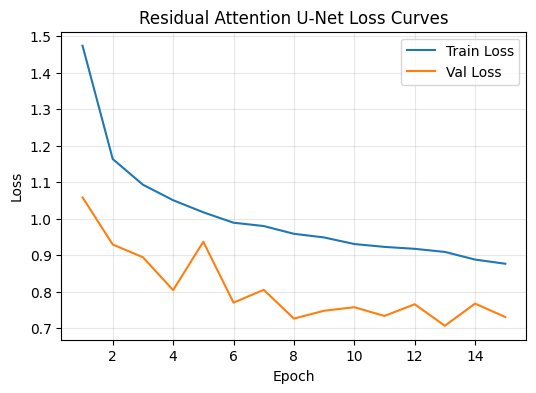

In [24]:
# Plot the losses
plt.figure(figsize=(6,4))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Residual Attention U-Net Loss Curves')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

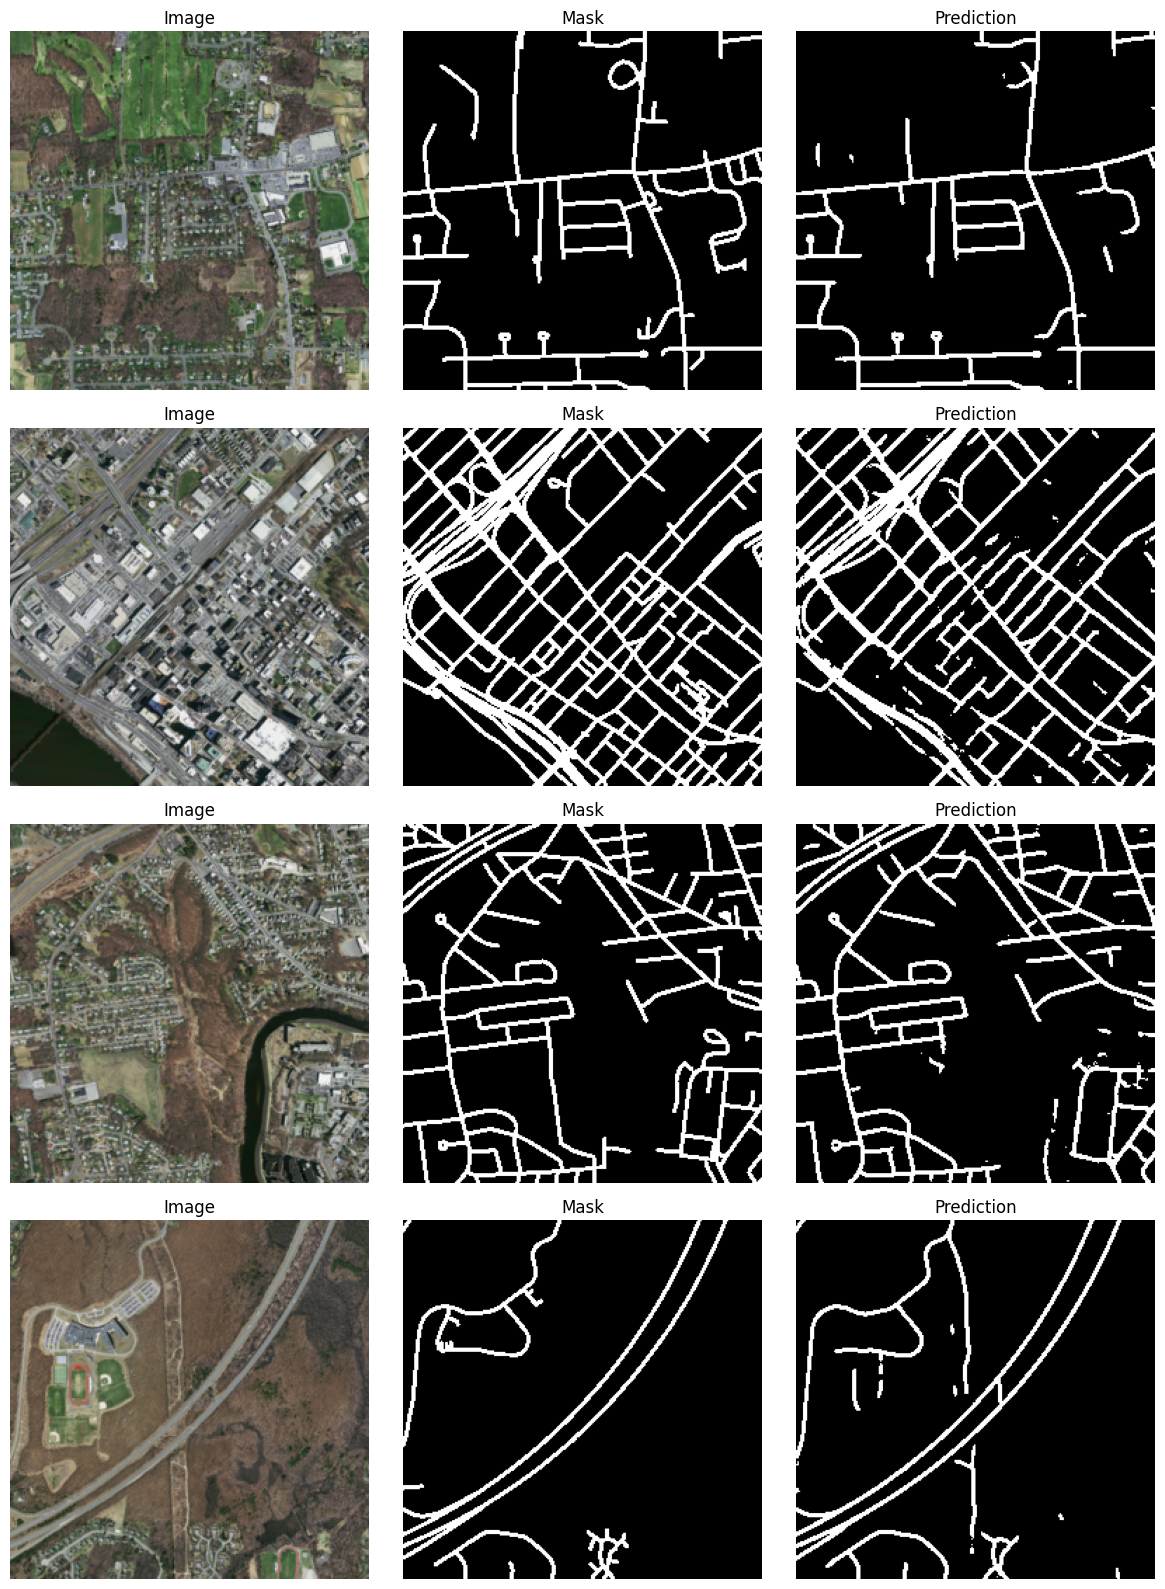

In [26]:
def visualize_image_mask_prediction(model, n=5):

    dev = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        imgs, msks = next(iter(val_loader))
        imgs, msks = imgs.to(dev), msks.to(dev)
        preds = model(imgs)

    images = imgs.cpu()
    masks = msks.cpu()
    predictions = preds.cpu()

    b = min(n, images.size(0))
    plt.figure(figsize=(12, 4 * b))
    for i in range(b):
        img  = images[i].permute(1, 2, 0).numpy()
        msk  = masks[i, 0].numpy()
        pred = (predictions[i, 0].numpy() > 0.5).astype(np.float32)

        plt.subplot(b, 3, 3*i + 1); plt.imshow(img);  plt.axis('off'); plt.title('Image')
        plt.subplot(b, 3, 3*i + 2); plt.imshow(msk,  cmap='gray'); plt.axis('off'); plt.title('Mask')
        plt.subplot(b, 3, 3*i + 3); plt.imshow(pred, cmap='gray'); plt.axis('off'); plt.title('Prediction')

    plt.tight_layout()
    plt.show()
# show results of residual attention UNet
visualize_image_mask_prediction(resattn_unet)